In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import astropy.units as u
from astropy.table import vstack, unique

Download the table of all known exoplanet host stars from the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu):

In [2]:
table = NasaExoplanetArchive.get_confirmed_planets_table(all_columns=True)

In [3]:
gaia_gmag = table['gaia_gmag']

Apply cuts to get only the brightest stars with $G < 12$, visible in the North, with spectroscopic surface gravities consistent with dwarf stars, that are known to transit.

In [118]:
cuts = ((gaia_gmag < 12) & (table['dec'] > -15*u.deg) & (table['st_logg'] < 5.5) & 
        (table['st_logg'] > 4.0) & (table['pl_tranflag'] == 1) & (table['st_teff'] < 7220 * u.K))

In [119]:
catalog = table[cuts]

In [120]:
catalog = unique(catalog, keys=['pl_hostname'])
catalog.write('tables/full_catalog.ecsv', format='ascii.ecsv')
del catalog['sky_coord']

In [75]:
catalog.sort(keys='ra')

In [76]:
coords = SkyCoord(catalog['ra'], catalog['dec'])

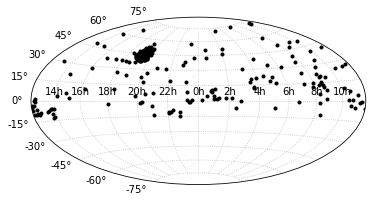

In [77]:
from astropy.coordinates import Angle

ax = plt.subplot(111, projection="hammer")
for coord in coords:
    ax.plot(coord.ra.wrap_at('180d').radian, coord.dec.radian, 'k.')
ax.grid(ls=':', color='silver')
xticks = np.arange(-150, 180, 30)
ax.set_xticks(np.radians(xticks))
ax.set_xticklabels(["{0:.0f}h".format(i if i >= 0 else i + 24) for i in Angle(xticks, u.deg).hour])
plt.savefig('plots/sky_coverage.pdf', bbox_inches='tight')

In [78]:
from astroplan import Observer, months_observable, AirmassConstraint, AtNightConstraint, LocalTimeConstraint
from datetime import time

constraints = [AirmassConstraint(max=1.5), 
               AtNightConstraint.twilight_astronomical()]

apo = Observer.at_site('APO')

observable_a = months_observable(constraints, apo, coords, time_grid_resolution=1 * u.hour)

In [79]:
xrange = np.zeros(13)

names = []
image_a = []
obs_coords = []
for s, c, row in zip(observable_a, coords, catalog):
    months = xrange.copy()
    
    if len(s) > 0:
        names.append(row['pl_hostname'])
        months[np.array(list(s))] = 1
        image_a.append(months[1:])
        obs_coords.append(c)
image_a = np.array(image_a)

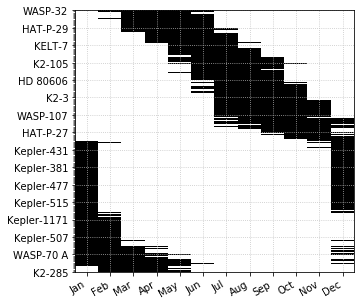

In [80]:
fig, axis = plt.subplots(1, 1, figsize=(5, 15))
axis.imshow(image_a, aspect=0.05, cmap=plt.cm.Greys_r)
# ax[1].imshow(image_b, aspect=0.05, cmap=plt.cm.Greys_r)

# for axis in ax:
xticks = np.arange(0, 12)
xticklabels = 'Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split()
axis.set_xticks(xticks)
skip = 15
axis.grid(ls=':', color='silver')
axis.set_yticks(np.arange(len(image_a)), minor=True)
axis.set_yticks(np.arange(len(image_a))[::skip])
axis.set_yticklabels(names[::skip])
axis.set_xticklabels(xticklabels, ha='right', rotation=30)
fig.savefig('plots/visibility.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [81]:
from astropy.table import Table

target_list = Table([catalog['pl_hostname'], catalog['gaia_gmag'], catalog['ra_str'], catalog['dec_str']], names=['Name', 'G', 'RA', 'Dec'])

target_list.write('table.tex', format='ascii.latex')

In [82]:
len(names)

230

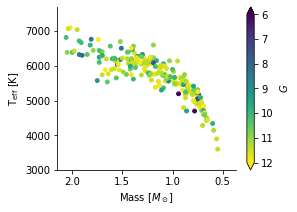

In [115]:
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(4, 3))
cax = ax.scatter(catalog['st_rad'].value, catalog['st_teff'], c=catalog['gaia_gmag'], s=15, 
                 norm=Normalize(vmin=6, vmax=12))
cbar = plt.colorbar(cax, label='$G$', extend='both')
ax.invert_xaxis()
cbar.ax.invert_yaxis() 
ax.set_ylim([3000, 7700])
ax.set_xlabel('Mass [$M_\odot$]')
ax.set_ylabel('$\\rm T_{eff}$ [K]')

for sp in ['right', 'top']:
    ax.spines[sp].set_visible(False)
fig.savefig('plots/color_mass.pdf', bbox_inches='tight')

In [70]:
# d_pc = (catalog['gaia_plx'] * u.mas).to(u.pc, u.parallax())

# abs_mag_G = catalog['gaia_gmag'] - 5 * np.log10(d_pc.value) + 5
# teff = catalog['st_teff']

# fig, ax = plt.subplots(figsize=(4, 3))
# ax.scatter(teff[teff > 0*u.K], abs_mag_G[teff > 0*u.K])
# ax.invert_yaxis()
# ax.invert_xaxis()
# ax.set_xscale('log')